# Stablised Bi-Conjugate Gradient Method

***You must have completed the exercises on the worksheet about matrix assembly before proceeding***


**BiCGStab** a Krylov-subspace method.  These are a class of mathematical methods for solving the system of equations A**x** = **b** which can be proved to converge in _N_ itterations.  We don't know what _N_ is and it may be quite large but it is not infinite.  The Jacobi, Gauss-Siedel and SOR schemes, on the other hand, can only be shown to solve  A**x** = **b** exactly after an infinite number of itterations!

Like all Krylov-subspace methods **BiCGStab** is a complicated algorithm and coding it efficiently and without error takes care and attention.  Fortunately `scipy.linalg` provides efficient implementatons of the most common Krylov-subspace methods including **BiCGStab**.

When solving elliptical problems (or large linear systems) it is best to use professional written library routines like **BiCGStab**.  These will make most efficient use of the processor pipeline resulting in a faster runtime and lower a cost of computation (in terms of energy usage).

As before we are going to use our Grid Class

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import time

class Grid:
    '''Class defining a 2D computational grid.  The grid object
    contains is a regular cartesian grid with a single variable, u.
    It stores information about the number of grid points in the i
    and j directions, the ordinates of these points and the bottom
    left corner of the gird (the origin) and the top right corner
    (the extent).
    
    Written by Prof David Ingram, School of Engineering
    (c) 2021 The University of Edinburgh
    Licensed under CC-BY-NC.'''
    
    DIRICHLET_BC = 0
    NEUMANN_BC = 1

    BC_NAME = ['left', 'right', 'top', 'bottom']
    
    def __init__(self,ni,nj):
        # set up information about the grid
        self.origin = (0.0, 0.0)  # bottom left
        self.extent = (1.0, 1.0)  # top right
        self.Ni = ni # grid points in i direction
        self.Nj = nj # grid points in j direction
        
        # initialse x,y and u arrays
        self.u = np.zeros((nj, ni))
        self.x = np.zeros((nj, ni))
        self.y = np.zeros((nj, ni))
        
        # boundary conditions (left right top and bottom)
        self.BC = [self.DIRICHLET_BC, self.DIRICHLET_BC, 
                   self.DIRICHLET_BC, self.DIRICHLET_BC]

    def set_origin(self,x0,y0):
        self.origin = (x0, y0)
    
    def set_extent(self,x1,y1):
        self.extent = (x1, y1)
        
    def generate(self,Quiet=True):
        '''generate a uniformly spaced grid covering the domain from the
        origin to the extent.  We are going to do this using linspace from
        numpy to create lists of x and y ordinates and then the meshgrid
        function to turn these into 2D arrays of grid point ordinates.'''
        x_ord = np.linspace(self.origin[0], self.extent[0], self.Ni)
        y_ord = np.linspace(self.origin[1], self.extent[1], self.Nj)
        self.x, self.y = np.meshgrid(x_ord,y_ord)
        if not Quiet:
            print(self)

    def Delta_x(self):
        # calculate delta x
        return self.x[0,1]-self.x[0,0]
    
    def Delta_y(self):
        # calculate delta y
        return self.y[1,0]-self.y[0,0]
    
    def find(self,point):
        '''find the i and j ordinates of the grid cell which contains 
        the point (x,y).  To do this we calculate the distance from
        the point to the origin in the x and y directions and then
        divide this by delta x and delta y.  The resulting real ordinates
        are converted to indices using the int() function.'''
        grid_x = (point[0] - self.origin[0])/self.Delta_x()
        grid_y = (point[1] - self.origin[1])/self.Delta_y()
        return int(grid_x), int(grid_y)
    
    def set_Neumann_bc(self,side):
        try:
             self.BC[self.BC_NAME.index(side)] = self.NEUMANN_BC
        except:
             print('error {} must be one of {}'.format(side,self.BC_NAME))
     
    def set_Dirichlet_bc(self,side):
        try:
            self.BC[self.BC_NAME.index(side)] = self.DIRICHLET_BC
        except:
            print('error {} must be one of {}'.format(side,self.BC_NAME))
    
    def report_BC(self):
        '''compile a string listing the boundary conditions on each side.
        We build up a string of four {side name}: {BC type} pairs and
        return it'''
        
        # initialise the string
        string = ''
        
        # loop over the sides
        for side in range(4):
            # add the side name
            string = string + self.BC_NAME[side]
            # and the bounday condition type
            if self.BC[side] == self.DIRICHLET_BC:
                string = string + ': Dirichlet, '
            elif self.BC[side] == self.NEUMANN_BC:
                string = string + ': Neumann, '
        return string[:-2] +'.' # lose the last comma and space.
    
    def __str__(self):
        # describe the object when asked to print it
        describe = 'Uniform {}x{} grid from {} to {}.'.format(self.Ni, self.Nj, self.origin, self.extent)
        boundaries = self.report_BC()
        return describe + '\nBoundaries conditions are - ' + boundaries

## Matrix Assembly
Because **BiCGStab** (and the other Krylov-subspace methods) are designed to solve A**x** = **b** our solver must construct the coefficient matrix _A_ andf the right hand side vector **b**.  _A_ will be an _N_ x _N_ matrix, where _N_ = _N<sub>i</sub>_ x _N<sub>j</sub>_. Because each linear equation only includes the coeeficients asociated with the North, East, South, West and Centre points of the stencil each row of A will have a maximum of five non-zero entries.  If we store  _A_  as a **sparse** matrix we will only store the non-zero values and we will use a lot less memory.

Our solution process is:
1. Assemble _A_ and **b**
2. Solve A**x** = **b** 
3. Unpack the solution vector, **x**, into the array `grid.u`

In assembling the matrix we are going to use the same ideas we used in accelerating the SOR solver. We will introduce an index _k_ 

    k = (i-1) + (Ni-2)*(j-1) 

where _k_ is the row number in the matrix _A_.  Unlike in the `Laplace-faster workbook` `i` and `j` will only loop over the interior points in the grid.

Let's try creating the coefficient matrix for a 11 x 11 grid and plotting it with `matplotlib.pyplot.spy()` which shows the non-zero values.

Uniform 11x11 grid from (0.0, 0.0) to (1.0, 1.0).
Boundaries conditions are - left: Dirichlet, right: Dirichlet, top: Dirichlet, bottom: Neumann.


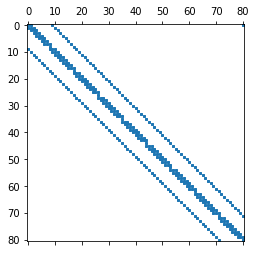

A matrix has 369 non-zero entries out of 6561 (94.4% sparsity)


In [2]:
import scipy.sparse as sps

# a simple test problem using the Unit Square with the bottom bounday
# as a Neumann boundary condition. All the Dirichlet boundaries are 
# set to u=1 (so nothing will happen).

test = Grid(11,11)
test.u[:,:]=1
test.set_Neumann_bc('bottom')
test.generate()
print(test)

# we will create the matrix using the lil format, this is
# fast for row opperations.
N = (test.Nj-2)*(test.Ni-2)
A_mat = sps.lil_matrix((N, N), dtype=np.float64)

# matrix assembly  This time we will only put a 1 in the matrix to 
# indicate non-zero values

for j in range(1, test.Nj-1):
    for i in range(1, test.Ni-1):
        k = (i-1) + (test.Ni-2)*(j-1)
        A_mat[k,k]=1
        # North boundary
        if j<test.Nj-2:
            A_mat[k,k+(test.Ni-2)]=1
        # South boundary
        if j>1:
            A_mat[k,k-(test.Ni-2)]=1
        # East boundary
        if i<test.Ni-2:
            A_mat[k,k+1]=1
        # West boundary
            A_mat[k,k-1]=1

plt.spy(A_mat, markersize=2, aspect='equal')
plt.show()

print('A matrix has {} non-zero entries out of {} ({:.1f}% sparsity)'.format
      (A_mat.nnz,N**2,(1-A_mat.nnz/(N**2))*100))

We can see the penta-diagonal matrix structure we expected.

## Coefficient values
We now need to fill in the correct coefficient values.

If we look at our linear system we have (for an interior point)
$$u_O-\frac{1}{2(1+\beta^2)}(u_E+u_W)-\frac{\beta^2}{2(1+\beta^2)}(u_N+u_S)=0.$$
So the coefficients of the East and West points are
$$r_x=-\frac{1}{2(1+\beta^2)}$$
and the coefficients of the North and South points are
$$r_y=-\frac{\beta^2}{2(1+\beta^2)}.$$

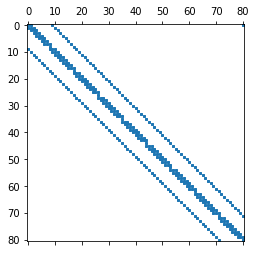

A matrix has 369 non-zero entries out of 6561 (94.4% sparsity)


In [3]:
# recreate A
A_mat = sps.lil_matrix((N, N), dtype=np.float64)

# calculate the coefficients
beta = test.Delta_x()/test.Delta_y()
beta_sq = beta**2
R_x = - 1/(2*(1+beta_sq))
R_y = beta_sq * R_x

# matrix assembly  This time we will only put a 1 in the matrix to 
# indicate non-zero values
for j in range(1, test.Nj-1):
    for i in range(1, test.Ni-1):
        k = (i-1) + (test.Ni-2)*(j-1)
        A_mat[k,k]=1
        # North boundary
        if j<test.Nj-2:
            A_mat[k,k+(test.Ni-2)]=R_y
        # South boundary
        if j>1:
            A_mat[k,k-(test.Ni-2)]=R_y
        # East boundary
        if i<test.Ni-2:
            A_mat[k,k+1]=R_x
        # West boundary
            A_mat[k,k-1]=R_x

plt.spy(A_mat, markersize=2, aspect='equal')
plt.show()

print('A matrix has {} non-zero entries out of {} ({:.1f}% sparsity)'.format
      (A_mat.nnz,N**2,(1-A_mat.nnz/(N**2))*100))


## The RHS vector, **b**.

At the same time as we assemble _A_ we need to fill in the values of **b**.  We know that if we have a Dirichlet boundary condition on the East or West boundaries then 
$$b_k=-r_x u_{bc},$$
while on the North and South boundaries
$$b_k=-r_y u_{bc}.$$

In the case of the Neumann boundary condition _b<sub>k</sub>_= 0 **but** the coefficient of the interior point in the _A_ matrix must be updated.  The following table gives the actions:

| boundary | Dirichlet | Neumann |
|----------|-----------|---------|
| North|  `b[k] = -Ry*u[j+1,i]` | `A[k,k+(Ni-2)] = 2*A[k,k+(Ni-2)]` |
| East | `b[k] = -Rx*u[j,i+1]` | `A[k,k+1] = 2*A[k,k+1]` |
| South | `b[k] = -Ry*u[j-1,i]` | `A[k,k-(Ni-2)] = 2*A[k,k-(Ni-2)]` |
| West | `b[k] = -Rx*u[,i-1]` | `A[k,k-1] = 2*A[k,k-1]` |



In [4]:
# create A and b
A_mat = sps.lil_matrix((N, N), dtype=np.float64)
b_vec = np.zeros(N)

# calculate the coefficients
beta = test.Delta_x()/test.Delta_y()
beta_sq = beta**2
R_x = - 1/(2*(1+beta_sq))
R_y = beta_sq * R_x

# matrix assembly 
for j in range(1, test.Nj-1):
    for i in range(1, test.Ni-1):
        k = (i-1) + (test.Ni-2)*(j-1)
        A_mat[k,k]=1
        
        # North boundary
        if j<test.Nj-2:
            A_mat[k,k+(test.Ni-2)] += R_y
        elif (test.BC[2]== test.NEUMANN_BC):
            A_mat[k,k-(test.Ni-2)] += R_y
        else:
            b_vec[k] += -R_y*test.u[j+1,i]
            
        # South boundary
        if j>1:
            A_mat[k,k-(test.Ni-2)]=R_y
        elif (test.BC[3]== test.NEUMANN_BC):
            A_mat[k,k+(test.Ni-2)] += R_y
        else:
            b_vec[k] += -R_y*test.u[j-1,i]
            
        # East boundary
        if i<test.Ni-2:
            A_mat[k,k+1]=R_x
        elif (test.BC[1]== test.NEUMANN_BC):
            A_mat[k,k-1] += R_y
        else:
            b_vec[k] += -R_y*test.u[j,i+1]
            

        # West boundary
        if i>1:
            A_mat[k,k-1]=R_x
        elif (test.BC[0]== test.NEUMANN_BC):
            A_mat[k,k+1] += R_y
        else:
            b_vec[k] += -R_y*test.u[j,i-1]

print(b_vec)

[0.25 0.   0.   0.   0.   0.   0.   0.   0.25 0.25 0.   0.   0.   0.
 0.   0.   0.   0.25 0.25 0.   0.   0.   0.   0.   0.   0.   0.25 0.25
 0.   0.   0.   0.   0.   0.   0.   0.25 0.25 0.   0.   0.   0.   0.
 0.   0.   0.25 0.25 0.   0.   0.   0.   0.   0.   0.   0.25 0.25 0.
 0.   0.   0.   0.   0.   0.   0.25 0.25 0.   0.   0.   0.   0.   0.
 0.   0.25 0.5  0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.5 ]


# Calling the solver
Now we can call the solver


In [5]:
import scipy.sparse.linalg as LA

# call bicgstab
x_vec, info = LA.bicgstab(A_mat,b_vec,tol=0.5e-12)
if info==0:
    print('Solved ')
    print(' x =',x_vec)
else:
    print('Error code =',info)


Solved 
 x = [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1.]


This is what we wanted to happen.

## Putting it all together

We can now write a function to solve the system

In [6]:
def LaplaceSolver(grid,tol=0.5e-7):
    '''Solve the two dimensional laplace equation using the bi-conjugate
    gradient stabilised matrix solver (BiCGStab).  This function assembles
    the coeficient matrix A and the RHS vector b taking account of the 
    boundary conditions specified in the grid object and calls the sparse
    BiCGStab solver from scipy.  The value tol is passed to BiCGStab routine
    The solution vector x is then unpacked into grid.u. It returns the info
    value from BiCGStab if this is zero everything worked.
    
    Writen by D Ingram
    (c) 2021 The University of Edinburgh
    Licenced CC-BY.
    '''
    
    # Create the A matrix using the lil format and the b vector
    # as numpy vector.
    N = (grid.Nj-2)*(grid.Ni-2)
    A_mat = sps.lil_matrix((N, N), dtype=np.float64)
    b_vec = np.zeros(N, dtype=np.float64)

    # calculate the coefficients
    beta = grid.Delta_x()/grid.Delta_y()
    beta_sq = beta**2
    R_x = - 1/(2*(1+beta_sq))
    R_y = beta_sq * R_x


    # matrix assembly. We're going to use += to add values to the matrix
    # coeeficients and the RHS vector as boundary conditions could cause
    # issues.  This is safe to do because both np.zeros and the sparse
    # matrix creator initialise the values in the arrays to zero.
    for j in range(1, grid.Nj-1):
        for i in range(1, grid.Ni-1):
            k = (i-1) + (grid.Ni-2)*(j-1)
            A_mat[k,k]=1
        
            # Left boundary
            if i>1:
                A_mat[k,k-1] += R_x
            elif (grid.BC[0] == grid.NEUMANN_BC):
                A_mat[k,k+1] += R_x
            else:
                b_vec[k] += -R_x*grid.u[j,i-1]

            # Right boundary
            if i<grid.Ni-2:
                A_mat[k,k+1] +=R_x
            elif (grid.BC[1] == grid.NEUMANN_BC):
                A_mat[k,k-1] += R_x
            else:
                b_vec[k] += -R_x*grid.u[j,i+1]
            
            # Bottom boundary
            if j>1:
                A_mat[k,k-(grid.Ni-2)] += R_y
            elif (grid.BC[3]== grid.NEUMANN_BC):
                A_mat[k,k+(grid.Ni-2)] += R_y
            else:
                b_vec[k] += -R_y*grid.u[j-1,i]
   
            # South boundary
            if j<grid.Nj-2:
                A_mat[k,k+(grid.Ni-2)] += R_y
            elif (grid.BC[2]== grid.NEUMANN_BC):
                A_mat[k,k-(grid.Ni-2)] += R_y
            else:
                b_vec[k] += -R_y*grid.u[j+1,i]

    # call bicgstab
    
    x_vec, info = LA.bicgstab(A_mat,b_vec,tol=tol)
    if info==0:
        # unpack x_vec into u
        for j in range(1, grid.Nj-1):
            for i in range(1, grid.Ni-1):
                k = (i-1) + (grid.Ni-2)*(j-1)
                grid.u[j,i]=x_vec[k]
    
    return info

## The original test problem
Were going to use the same test problem as before to make sure it still works! 

$$0=u_{xx}+u_{yy}$$
subject to the boundary conditions
$$\begin{align*}
u(x,0)&=0&0\le x\le 2 \\
u(x,1)&=0&0\le x\le 2 \\
u(0,y)&=0&0\le y \le 1\\
u(2,y)&=\sin 2\pi y&0\le y \le 1.
\end{align*}$$

In [7]:
def Example929(ni,nj):
    # set up a mesh
    mesh = Grid(ni,nj)
    mesh.set_extent(2.0,1.0)
    mesh.generate()
    # now the RHS boundary condition
    mesh.u[:,-1]=np.sin(2*np.pi*mesh.y[:,-1])
    return mesh

Uniform 161x81 grid from (0.0, 0.0) to (2.0, 1.0).
Boundaries conditions are - left: Dirichlet, right: Dirichlet, top: Dirichlet, bottom: Dirichlet.
Solver took 0.347 seconds.


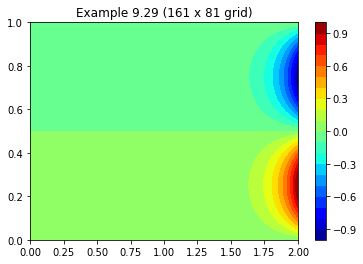

In [18]:
# Test problem on a fine grid
test = Example929(161,81)
print(test)

# run the solver
start = time.process_time()
info = LaplaceSolver(test)
stop = time.process_time()
print("Solver took {:.3g} seconds.".format(stop-start))

if info==0:
    # plot the solution
    fig, ax1 = plt.subplots()
    cmap = plt.get_cmap('PiYG')
    cf = ax1.contourf(test.x,test.y,test.u,cmap=cmap, levels = 21)
    fig.colorbar(cf, ax=ax1)
    ax1.set_title(f'Example 9.29 ({test.Ni} x {test.Nj} grid)')
    plt.show()
else:
    print('Error code ',info,' returned by BiCGStab')

### Porous Flow

Water seeping through a porous medium can be modelled using the Laplace equation.  If we have a "box" _z<sub>0</sub>_ meters tall and _s_ meters wide with a linear pressure gradient _h = z<sub>0</sub> + cx_ applied at the upper boundary, an impermeable base and constant flow boundaries on the left and right.  The pressure in the medium can be modlled as

$$h_{zz}+h_{xx}=0$$ with boundary conditions

$$h_z(x,0)=0,\,h_x(0,z)=0\text{ and }h_x(s,z)=0$$
and
$$h(x,z_0)=z_0+c x.$$

This test problem has an anlytical solution developed by Toth (1962):
$$h(x,z) = z_0+\frac{cs}{2}-\frac{4cs}{\pi^2}\sum_{m=0}^\infty 
\frac{\cos[(2m+1)\pi x/s]\cosh[(2m+1)\pi z/s]}
{(2m+1)^2\cosh[(2m+1)\pi z_0/s]}.$$

Let us consider a 200 wide by 100 m deep medium with _c_ = 0.176.

In [9]:
def porous(ni,nj):
    # set up a mesh
    mesh = Grid(ni,nj)
    mesh.set_extent(200.0,100.0)
    mesh.generate()
    # set the boundary conditions
    mesh.set_Neumann_bc('left')
    mesh.set_Neumann_bc('right')
    mesh.set_Neumann_bc('bottom')

    # now the top boundary condition
    mesh.u[-1,:]=100.0 + 0.176 * mesh.x[-1,:]
    return mesh    

Uniform 161x81 grid from (0.0, 0.0) to (200.0, 100.0).
Boundaries conditions are - left: Neumann, right: Neumann, top: Dirichlet, bottom: Neumann.
Solver took 1.65 seconds.


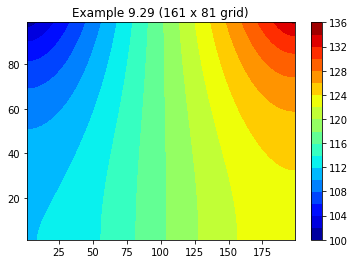

In [10]:
# Test problem on a fine grid
test = porous(161,81)
print(test)

# run the solver
start = time.process_time()
info = LaplaceSolver(test)
stop = time.process_time()
print("Solver took {:.3g} seconds.".format(stop-start))

if info==0:
    # plot the solution
    fig, ax1 = plt.subplots()
    cmap = plt.get_cmap('jet')
    cf = ax1.contourf(test.x[1:-1,1:-1],test.y[1:-1,1:-1],test.u[1:-1,1:-1],cmap=cmap,levels = 21)
    fig.colorbar(cf, ax=ax1)
    ax1.set_title(f'Example 9.29 ({test.Ni} x {test.Nj} grid)')
    plt.show()
else:
    print('Error code ',info,' returned by BiCGStab')

### Analysis
The `LaplaceSolver()` function is working effectively for both the test problems.  The runtime on a 161 x 81 grid is 5.11 seconds for the original test case and 6.98 seconds for the porous test case.  Compared with 2.54 seconds and 12 seconds for the SOR solver.  These could be reduced a little by writing the unpacking part of the function more efficiently.

We can speed up the `sparse.linalg.BiCGStab()` routine by using a pre-conditioner.  This computes an approximate inverse of _A_ which can be used to speed up the calculation.  In this case we will use the incomplete LU factorisation, `sparse.linalg.spilu()`.

The steps to do this are:
* assemble the _A_ matrix
* compute the incomplete LU facortisation _M_
* call BiCGStab passigf _A_, **b** and _M_.

A complexity is that `sparse.linalg.spilu()` uses a different format of matrix, fortunately the `lil` format is easily converted.  We replace the original call to `sparse.linalg.bicgstab()` with

    ilu = LA.spilu(A_mat.tocsc())
    M_mat = LA.LinearOperator(A_mat.shape, ilu.solve)
    x_vec, info = LA.bicgstab(A_mat,b_vec,tol=tol,M=M_mat)


In [11]:
def LaplaceSolver(grid,tol=0.5e-7):
    '''Solve the two dimensional laplace equation using the bi-conjugate
    gradient stabilised matrix solver (BiCGStab).  This function assembles
    the coeficient matrix A and the RHS vector b taking account of the 
    boundary conditions specified in the grid object and calls the sparse
    BiCGStab solver from scipy.  The value tol is passed to BiCGStab routine
    The solution vector x is then unpacked into grid.u. It returns the info
    value from BiCGStab if this is zero everything worked.
    
    Writen by D Ingram
    (c) 2021 The University of Edinburgh
    Licenced CC-BY.
    '''
    
    # Create the A matrix using the lil format and the b vector
    # as numpy vector.
    N = (grid.Nj-2)*(grid.Ni-2)
    A_mat = sps.lil_matrix((N, N), dtype=np.float64)
    b_vec = np.zeros(N, dtype=np.float64)

    # calculate the coefficients
    beta = grid.Delta_x()/grid.Delta_y()
    beta_sq = beta**2
    R_x = - 1/(2*(1+beta_sq))
    R_y = beta_sq * R_x


    # matrix assembly. We're going to use += to add values to the matrix
    # coeeficients and the RHS vector as boundary conditions could cause
    # issues.  This is safe to do because both np.zeros and the sparse
    # matrix creator initialise the values in the arrays to zero.
    for j in range(1, grid.Nj-1):
        for i in range(1, grid.Ni-1):
            k = (i-1) + (grid.Ni-2)*(j-1)
            A_mat[k,k]=1
        
            # Left boundary
            if i>1:
                A_mat[k,k-1] += R_x
            elif (grid.BC[0] == grid.NEUMANN_BC):
                A_mat[k,k+1] += R_x
            else:
                b_vec[k] += -R_x*grid.u[j,i-1]

            # Right boundary
            if i<grid.Ni-2:
                A_mat[k,k+1] +=R_x
            elif (grid.BC[1] == grid.NEUMANN_BC):
                A_mat[k,k-1] += R_x
            else:
                b_vec[k] += -R_x*grid.u[j,i+1]
            
            # Bottom boundary
            if j>1:
                A_mat[k,k-(grid.Ni-2)] += R_y
            elif (grid.BC[3]== grid.NEUMANN_BC):
                A_mat[k,k+(grid.Ni-2)] += R_y
            else:
                b_vec[k] += -R_y*grid.u[j-1,i]
   
            # South boundary
            if j<grid.Nj-2:
                A_mat[k,k+(grid.Ni-2)] += R_y
            elif (grid.BC[2]== grid.NEUMANN_BC):
                A_mat[k,k-(grid.Ni-2)] += R_y
            else:
                b_vec[k] += -R_y*grid.u[j+1,i]

    # call bicgstab with an ILU preconditioner, drop_tol and
    # fill factor control the accuracy of the ILU approximation.
    ilu = LA.spilu(A_mat.tocsc(), drop_tol=1e-6, fill_factor=100)
    M_mat = LA.LinearOperator(A_mat.shape, ilu.solve)
    x_vec, info = LA.bicgstab(A_mat,b_vec,atol=tol,M=M_mat)

    if info<=0:
        # unpack x_vec into u
        for j in range(1, grid.Nj-1):
            for i in range(1, grid.Ni-1):
                k = (i-1) + (grid.Ni-2)*(j-1)
                grid.u[j,i]=x_vec[k]
    
    return info



Uniform 161x81 grid from (0.0, 0.0) to (200.0, 100.0).
Boundaries conditions are - left: Neumann, right: Neumann, top: Dirichlet, bottom: Neumann.
Solver took 0.392 seconds.


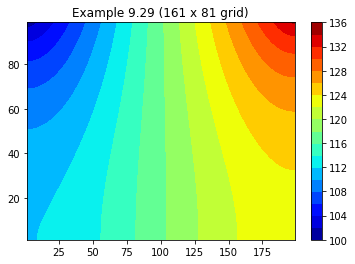

In [12]:
# Test problem on a fine grid
test = porous(161,81)
print(test)

# run the solver
start = time.process_time()
info = LaplaceSolver(test)
stop = time.process_time()
print("Solver took {:.3g} seconds.".format(stop-start))

if info==0:
    # plot the solution
    fig, ax1 = plt.subplots()
    cmap = plt.get_cmap('jet')
    cf = ax1.contourf(test.x[1:-1,1:-1],test.y[1:-1,1:-1],test.u[1:-1,1:-1],cmap=cmap,levels = 21)
    fig.colorbar(cf, ax=ax1)
    ax1.set_title(f'Example 9.29 ({test.Ni} x {test.Nj} grid)')
    plt.show()
else:
    print('Error code ',info,' returned by BiCGStab')

Using the preconditioner has reduced the runtime from 0.52 seconds to 8.17 (16 times faster). 

# final test

Lets use the original test problem and the integrate function to re-run our mesh refinement test.  Once again I'm starting with the massively fine 1281 x 641 grid.

In [13]:
import scipy.integrate as integrate
from refinement_analysis import refinement_analysis

def integrate_u_dx(mesh,x0,x1,y):
    '''Calculate U=\int_{1.0}^{1.95)u(x,0.25) dx  using the
    u value stored on the grid and simpsons rule'''
    
    # find the left and right grid points
    i0,j = mesh.find((x0,y))
    i1,j = mesh.find((x1,y))

    # add 1 to i1 as we are going to use it as an upper 
    # bound forarray slicing
    i1 = i1 +1
    
    # integrate
    return integrate.simps(mesh.u[j,i0:i1],mesh.x[j,i0:i1])



In [14]:
import datetime # just seconds may not be enough

# we need some lists u and dx values
U_val = []
dx_val = []
run_time = []
n_pts =[]
for grid_index in range(6,1,-1):
    ni = 20*2**grid_index + 1
    nj = 10*2**grid_index + 1
    n_pts.append(ni*nj)
    
    # set up the problem
    test = Example929(ni,nj)
    print(test)
    
    # solve it with 12 d.p. precision and a lot of itterations
    start = time.process_time()
    info = LaplaceSolver(test,tol=1e-15)
    stop = time.process_time()
    print("The solver took {}, the return code is {}" \
          .format(datetime.timedelta(seconds=int(stop-start)),info))

    # save dx and the integral
    dx_val.append(test.Delta_x())
    U_val.append(integrate_u_dx(test,1.0,1.95,0.25))
    run_time.append(stop-start)
          
    print('Integrated value is ',U_val[-1],'\n')

Uniform 1281x641 grid from (0.0, 0.0) to (2.0, 1.0).
Boundaries conditions are - left: Dirichlet, right: Dirichlet, top: Dirichlet, bottom: Dirichlet.
The solver took 0:01:06, the return code is 0
Integrated value is  0.11594998762485292 

Uniform 641x321 grid from (0.0, 0.0) to (2.0, 1.0).
Boundaries conditions are - left: Dirichlet, right: Dirichlet, top: Dirichlet, bottom: Dirichlet.
The solver took 0:00:08, the return code is 0
Integrated value is  0.1159547094362285 

Uniform 321x161 grid from (0.0, 0.0) to (2.0, 1.0).
Boundaries conditions are - left: Dirichlet, right: Dirichlet, top: Dirichlet, bottom: Dirichlet.
The solver took 0:00:01, the return code is 0
Integrated value is  0.11596933801411036 

Uniform 161x81 grid from (0.0, 0.0) to (2.0, 1.0).
Boundaries conditions are - left: Dirichlet, right: Dirichlet, top: Dirichlet, bottom: Dirichlet.
The solver took 0:00:00, the return code is 0
Integrated value is  0.11602661789026109 

Uniform 81x41 grid from (0.0, 0.0) to (2.0, 1

Refinement Analysis on 5 grids.

Grid Delta x ratio  \int_{75}^{125}h(x,25) dx
---------------------------------------------
   1 0.001563     2   0.11595
   2 0.003125     2  0.115955
   3 0.00625     2  0.115969
   4  0.0125     2  0.116027
   5   0.025   ---   0.11626
--------------------------------------------- 

order of convergence, p =   1.63

Grids       GCI
---------------
 1  2 2.426e-05
 2  3 7.516e-05
 3  4 0.0002943
 4  5  0.001197
---------------

 Grid Step  GCI Ratio Converged
-------------------------------
 1 2  2 3           1 True
 2 3  3 4      0.7913 False
 3 4  4 5      0.7619 False
-------------------------------



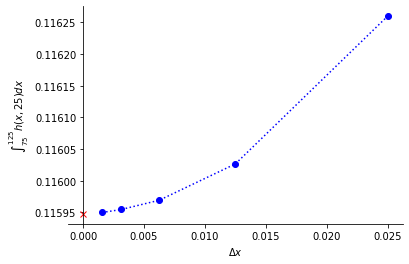

In [15]:
from refinement_analysis import refinement_analysis
# lets to the refinement analysis
analysis = refinement_analysis(dx_val,U_val)
analysis.report(r'\int_{75}^{125}h(x,25) dx')
analysis.plot(True,r'$\int_{75}^{125}h(x,25) dx$')

## Analysis
The runtime for preconditioned BiCGStab on the 1281 x 641 grid is 01:55 compared to 40:18 using the Jacobi solver (20 times faster).  The GCI analysis shows that the apparent order is 1.63 (so a little less than 2) but that the three finest grids are mesh converged.  The plot shows that the integrated quanity is approaching the limit anymptotically.  

Two minutes is a perfectly respectable runtime for solving this problem, and a similar time would be expected to solve the porous flow problem on the same grid.  Further improvements can be made by better selection of the pre-conditioner (although this is problem dependent) and optimisation of the matrix assembly and matrix unpacking code.